# <center> Innoscape - Telecom Paristech - Projet fil rouge </center>
# <center> Mapping Groupes de produits </center>

In [1]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import stats as scs
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random

from load_data import *
from preprocessing import *
from embedding import *
from item_selection import *
from product_categorization import *

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE

import plotly.plotly as py
import plotly.graph_objs as go
from numpy.random import randint

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

chemin = "../../Data/"

C:\Users\Pascal\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Importation des données et reformatage

In [2]:
# Chargement du csv avec les colonnes sélectionnées
df_seller = load_data(chemin + "t3_all_fr_prices_posweekly_prod_without_price.csv", columns_to_keep=[0, 1, 2, 3, 4, 13])

In [3]:
df_seller.head(5)

t3_all_fr_prices_posweekly_prod.prodcategory2_seller  \
0                                      Quincaillerie     
1                                                        
2                                        Accessoires     
3                                      Quincaillerie     
4           Peintures, outils et traitement des murs     

  t3_all_fr_prices_posweekly_prod.prodcategory3_seller  \
0                                 Colles et adhésifs     
1                                                        
2                   Accessoires pour lave-vaisselles     
3                                 Colles et adhésifs     
4                   Peintures, teintures et solvants     

  t3_all_fr_prices_posweekly_prod.prodcategory4_seller  \
0                                 Colles à carrelage     
1                                                        
2                                                        
3                                             Mastic     
4                                              Cires     

  t3_all_fr_prices_posweekly_prod.prodcategory1_seller  \
0                                          Bricolage     
1                                                        
2                                Gros électroménager     
3                                          Bricolage     
4                                          Bricolage     

  t3_all_fr_prices_posweekly_prod.productfamily_seller  \
0                                 Colles à carrelage     
1                                                        
2                                                        
3                                             Mastic     
4                                              Cires     

  t3_all_fr_prices_posweekly_prod.productseller_name  
0  SikaCeram Xtra - Colle à carrelage intérieur e...  
1  Ariston 3200362 scaldabagno elettrico PRO 100 H/3  
2  AEG Panier À Couverts Lave-vaisselle Cage & Ha...  
3              Colle-mastic pour joints d'étanchéité  
4  Sikagard Protection Sol MAT - Imperméabilisant...

In [4]:
# Importation des données références catégories Innoscape
df_ref = pd.read_excel(chemin + "reference_innoscape.xlsx")

#On garde que la colonne correspondante à la famille de produit de référence finale
columns_to_keep = ['innoscape_ref_productfamily_seller', 'label']
df_ref = df_ref[columns_to_keep]
df_ref = df_ref.drop_duplicates()

In [5]:
df_ref.head(5)

innoscape_ref_productfamily_seller  label
0                 Sol PVC en rouleau      1
1    Barre de seuil et nez de marche      2
2                 Parquet, stratifié      3
3            Accessoires chauffe-eau      4
4             Chauffe-eau électrique      5

In [6]:
# Importation de la liste de stop words
f = open(chemin + "stop_words.txt", "r")
stop_words = set(f.read().split('\n'))

g = open(chemin + "marques.txt", "r")
marques = set(g.read().split('\n'))

stop_words = stop_words | marques

In [7]:
#preprocessing des données
df_process_seller = preprocessing(df_seller, df_seller.columns, stop_words, tag_dir="C:/TreeTagger")

In [8]:
# All data set to create embedding
df_total = df_process_seller.fillna("")
df_total["concat"] = df_total['t3_all_fr_prices_posweekly_prod.productfamily_seller_clean'] + ' ' + \
                     df_total['t3_all_fr_prices_posweekly_prod.prodcategory4_seller_clean'] + ' ' + \
                     df_total['t3_all_fr_prices_posweekly_prod.prodcategory3_seller_clean'] + ' ' + \
                     df_total['t3_all_fr_prices_posweekly_prod.prodcategory2_seller_clean'] + ' ' + \
                     df_total['t3_all_fr_prices_posweekly_prod.prodcategory1_seller_clean'] + ' ' + \
                     df_total['t3_all_fr_prices_posweekly_prod.productseller_name_clean']

## Embedding (TF-IDF + NMF)

In [9]:
# Transformation en tfidf avec la librairie Sklearn
vectorizer = TfidfVectorizer(lowercase=False)
tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_total["concat"]))
tfidf_feature_names = vectorizer.get_feature_names()

In [10]:
nmf = NMF(n_components=250, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total)

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] + " " + str(round(topic[i],2))
                             for i in np.argwhere(topic>1).ravel().tolist()])
        print(message)
    print()

In [12]:
n_top_words = 4
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: tuile 13.33
Topic #1: accessoire 1.51 gouttiere 5.55 gros 1.07 œuvre 1.05
Topic #2: couverture 3.7 cuit 8.43 terre 8.47 tuile 5.33
Topic #3: adhesif 4.52 mastic 3.82 outillage 1.74 peinture 5.01 quincaillerie 2.12
Topic #4: electroportatif 6.63 outillage 2.21 quincaillerie 3.81
Topic #5: accessoire 1.49 bardage 4.0 charpente 5.09 materiau 1.85 materiaux 1.85 menuiserie 2.07 toiture 3.84
Topic #6: autoporte 2.94 jardin 1.07 tondeur 4.44 tondeuse 4.44
Topic #7: accessoire 1.28 bardage 2.03 gouttiere 6.54 mur 1.99 raccord 1.83 revetement 2.01 sol 2.15 toiture 1.95
Topic #8: bpe 2.67 gros 4.59 voirie 2.79 œuvre 4.52
Topic #9: enduire 1.45 finition 1.72 isolation 1.29 ite 4.19 platre 1.28
Topic #10: etancheite 6.68 toiture 2.18
Topic #11: batterie 1.02 fil 4.37 sans 4.69
Topic #12: chauffe 4.99 eau 4.03 plomberie 1.47
Topic #13: gauche 5.77 rive 4.24
Topic #14: batterie 4.75 chargeur 4.0 ion 1.19 lithium 1.52 outillage 1.28
Topic #15: bardage 2.27 couverture 7.05 gros 1.88 œuvre 1

## Fit Embedding

In [13]:
df_train = pd.read_csv(chemin + "df_train.csv")
df_train = df_train.fillna("")
df_train = df_train.iloc[:, 1:-1]

In [14]:
df_process_train = preprocessing(df_train, df_train.columns, stop_words, tag_dir="C:/TreeTagger")

In [15]:
df_train["concat"] = df_train['productfamily_seller_clean'] + ' ' + \
                     df_train['prodcategory4_seller_clean'] + ' ' + \
                     df_train['prodcategory3_seller_clean'] + ' ' + \
                     df_train['prodcategory2_seller_clean'] + ' ' + \
                     df_train['prodcategory1_seller_clean'] + ' ' + \
                     df_train['productseller_name_clean']

In [16]:
df_train.head()

productfamily_seller   prodcategory4_seller  \
0     Colles à carrelage     Colles à carrelage   
1                 Mastic                 Mastic   
2                  Cires                  Cires   
3      Perceuse visseuse              Perceuses   
4  Produits d étanchéité  Produits d étanchéité   

              prodcategory3_seller                     prodcategory2_seller  \
0               Colles et adhésifs                            Quincaillerie   
1               Colles et adhésifs                            Quincaillerie   
2  Peintures teintures et solvants  Peintures outils et traitement des murs   
3        Outillage électroportatif      Outillage à main et électroportatif   
4               Colles et adhésifs                            Quincaillerie   

  prodcategory1_seller                                 productseller_name  \
0            Bricolage  SikaCeram Xtra  Colle à carrelage intérieur et...   
1            Bricolage              Colle mastic pour joints d étanchéité   
2            Bricolage  Sikagard Protection Sol MAT  Imperméabilisant ...   
3            Bricolage  Perceuse visseuse RYOBI 18V OnePlus  1 batteri...   
4            Bricolage  Sika Multiseal  Bande d étanchéité autocollant...   

  productfamily_seller_treetagger prodcategory4_seller_treetagger  \
0               colle a carrelage               colle a carrelage   
1                          mastic                          mastic   
2                            cire                            cire   
3        perceur visseur|visseuse                         perceur   
4            produit d etancheite            produit d etancheite   

  prodcategory3_seller_treetagger      prodcategory2_seller_treetagger  \
0                colle et adhesif                        quincaillerie   
1                colle et adhesif                        quincaillerie   
2    peinture teinture et solvant  peinture outil et traitement du mur   
3       outillage electroportatif  outillage a main et electroportatif   
4                colle et adhesif                        quincaillerie   

  prodcategory1_seller_treetagger  \
0                       bricolage   
1                       bricolage   
2                       bricolage   
3                       bricolage   
4                       bricolage   

                       productseller_name_treetagger  \
0  sikaceram xtra coller a carrelage interieur et...   
1               colle mastic pour joint d etancheite   
2  sikagard protection sol mat impermeabiliser po...   
3  perceur visseur|visseuse ryobi v oneplus batte...   
4  sika multiseal bander d etancheite autocollant...   

  productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
1                     mastic                     mastic   
2                       cire                       cire   
3   perceur visseur|visseuse                    perceur   
4         produit etancheite         produit etancheite   

  prodcategory3_seller_clean      prodcategory2_seller_clean  \
0              adhesif colle                   quincaillerie   
1              adhesif colle                   quincaillerie   
2  solvant teinture peinture   peinture mur outil traitement   
3  outillage electroportatif  electroportatif main outillage   
4              adhesif colle                   quincaillerie   

  prodcategory1_seller_clean  \
0                  bricolage   
1                  bricolage   
2                  bricolage   
3                  bricolage   
4                  bricolage   

                            productseller_name_clean  \
0  exterieur interieur coller xtra carreau max ca...   
1                      colle mastic etancheite joint   
2  sikagard protection mat effet impermeabiliser sol   
3  perceur chargeur visseur|visseuse lithium rcd ...   
4  multiseal dechirure bander etancheite cuit ter...   

                                              concat  
0  colle carre

In [17]:
# Transform
tf_idf_train = sparse.csr_matrix(vectorizer.transform(df_train["concat"]))
df_train["nmf"] = nmf.transform(tf_idf_train).tolist()

In [20]:
X = np.array(df_train['nmf'].apply(lambda x: np.array(x)).tolist())

## Visualization of the data embedded according to Topic/Label

In [99]:
# Table for correspondance label index <-> label name
label_name = pd.read_excel(chemin + "reference_innoscape.xlsx")
label = pd.read_csv(chemin + "df_train.csv").iloc[:,-1]
dict_label_name = dict(zip(label_name.label.values, label_name["innoscape_ref_productfamily_seller"].values))

# For more information in scatterplot
text_product = df_train.productseller_name.values + ' (' + label.apply(lambda x: dict_label_name[x]).values + ')'

In [38]:
# Transform data from 200D to 3D
X_tsne = TSNE(n_components=3, perplexity=50, init='pca').fit_transform(X)

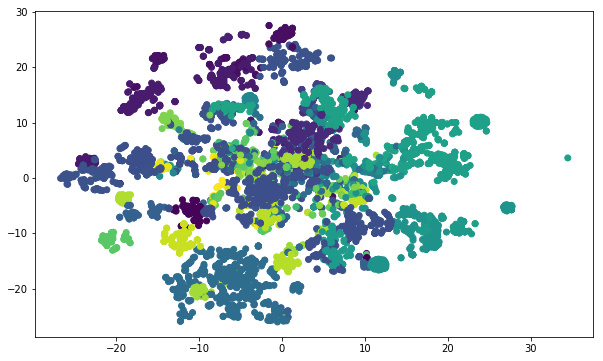

In [40]:
# 2D viz
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label.values)
plt.show()

In [100]:
# Get Topics
topics = nmf.components_
vocab = tfidf_feature_names

In [101]:
# Define top words of every topic
topic_summaries = []
for topic in topics:
    list_top_words = [vocab[i] for i in np.argwhere(topic>1).ravel().tolist()]
    topic_summaries.append('topic ' + ' '.join(list_top_words))
dico_topics = dict(zip(range(250), topic_summaries))

In [102]:
# Define top topic (max weigth) of the product data
list_topic_product = np.argmax(X, axis=1)

In [103]:
# Define product family name for every label index
dico_label = dict(zip(label_name.label.values, label_name.innoscape_ref_productfamily_seller.values))

In [104]:
# For grouping the products by topic and give a certain color/title for the plot
list_topic_product_indexes = []
for topic in list(set(list_topic_product)):
    list_topic_product_indexes.append((topic, np.argwhere(list_topic_product==topic).ravel().tolist()))

In [109]:
# For grouping the products by label and give a certain color/title for the plot
list_labels = []
for label_unique in list(set(label.values)):
    list_labels.append((label_unique, np.argwhere(label.values==label_unique).ravel().tolist()))

### Visualize data / topics

In [79]:
# 3D scatter plot with Dash
list_trace = []
for topic in list_topic_product_indexes:
    trace = go.Scatter3d(
        x=X_tsne[topic[1],0],
        y=X_tsne[topic[1],1],
        z=X_tsne[topic[1],2],
        mode='markers',
        name=dico_topics[topic[0]],
        text=text_product[topic[1]],
        marker=dict(
            size=12,
            line=dict(
                color='rgba('+str(randint(0, 255))+','+str(randint(0, 255))+','+str(randint(0, 255))+',0.14)',
                width=0.5
            ),
            opacity=0.8
        )
    )
    list_trace.append(trace)
data = list_trace
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

C:\Users\Pascal\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### Visualize data / labels

In [113]:
# 3D scatter plot with Dash
list_trace = []
for label_unique in list_labels:
    trace = go.Scatter3d(
        x=X_tsne[label_unique[1],0],
        y=X_tsne[label_unique[1],1],
        z=X_tsne[label_unique[1],2],
        mode='markers',
        name=dico_label[label_unique[0]],
        marker=dict(
            size=12,
            line=dict(
                color='rgba('+str(randint(0, 255))+','+str(randint(0, 255))+','+str(randint(0, 255))+',0.14)',
                width=0.5
            ),
            opacity=0.8
        )
    )
    list_trace.append(trace)
data = list_trace
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

C:\Users\Pascal\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

